# PU rejection BDT HLS implementation

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from optparse import OptionParser
from sklearn import metrics
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import sys
import os

import hls4ml
import joblib
import conifer
from scipy.special import expit
os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']

np.random.seed(7)

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)

def load_obj(source):
    with open(source,'rb') as f:
        return pickle.load(f)

/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/hls4ml_instruct_cnn/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
options = {
    'v'          : '12',
    'date'       : '2022_10_04',
    'inTag'      : '_lTauPtCut18_lEtacut1.5',
}

In [3]:
indir = '/data_CMS/cms/motta/Phase2L1T/'+options['date']+'_v'+options['v']
identdir = indir+'/TauBDTIdentifierTraining'+options['inTag']
calibdir = indir+'/TauBDTCalibratorTraining'+options['inTag']

In [4]:
Xident = pd.read_pickle(identdir+'/X_Ident_BDT_forEvaluator.pkl')
Xcalib = pd.read_pickle(calibdir+'/X_Calib_BDT_forEvaluator.pkl')

In [12]:
IDmodel = xgb.Booster()
CALmodel = xgb.Booster()

IDmodel.load_model(identdir+'/TauBDTIdentifier/PUmodel.model')
CALmodel.load_model(calibdir+'/TauBDTCalibrator/C2model.model')

In [13]:
IDfeats  = ['cl3d_pt', 'cl3d_coreshowerlength', 'cl3d_srrtot', 'cl3d_srrmean', 'cl3d_hoe', 'cl3d_meanz']
CALfeats = ['cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_abseta', 'cl3d_spptot', 'cl3d_srrmean', 'cl3d_meanz']
featuresN = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5']

In [29]:
Xident['cl3d_abseta'] = abs(Xident['cl3d_eta'])
Xcalib['cl3d_abseta'] = abs(Xcalib['cl3d_eta'])

for i in range(len(IDfeats)): Xident[featuresN[i]] = Xident[IDfeats[i]].copy(deep=True)
for i in range(len(CALfeats)): Xcalib[featuresN[i]] = Xcalib[CALfeats[i]].copy(deep=True)

In [30]:
Xident_reduced = Xident.head(3000)
Xcalib_reduced = Xcalib.head(3000)

# Identification model first

In [17]:
IDcfg = conifer.backends.vhdl.auto_config()
IDcfg['OutputDir'] = identdir+'/BDTmodel_VHDL'
IDcfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'
IDcfg['InputPrecision'] = 'ap_ufixed<24,11,AP_RND_CONV,AP_SAT>'

for key in IDcfg:
    print(key, ':', IDcfg[key])

ProjectName : my-prj
OutputDir : /data_CMS/cms/motta/Phase2L1T/2022_10_04_v12/TauBDTIdentifierTraining_lTauPtCut18_lEtacut1.5/BDTmodel_VHDL
Precision : ap_fixed<18,6,AP_RND_CONV,AP_SAT>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 5


In [18]:
# Create and compile the model
IDmodel_cnf = conifer.model(IDmodel, conifer.converters.xgboost, conifer.backends.vhdl, IDcfg)
IDmodel_cnf.compile()

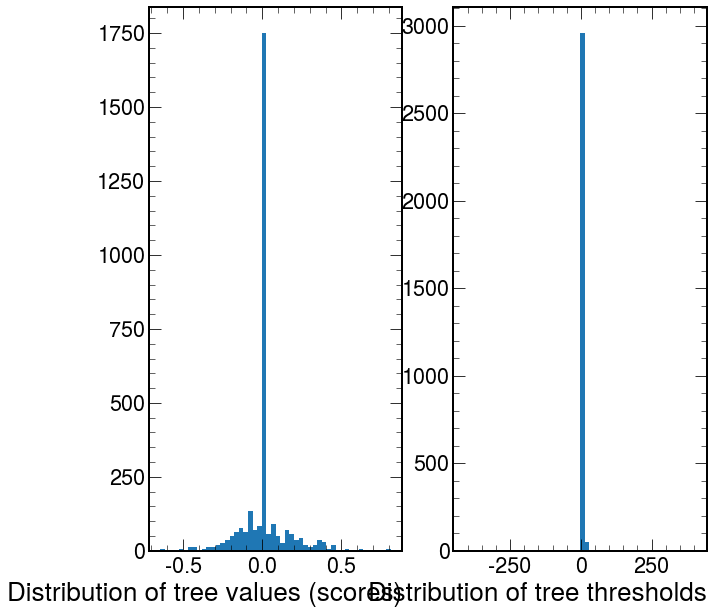

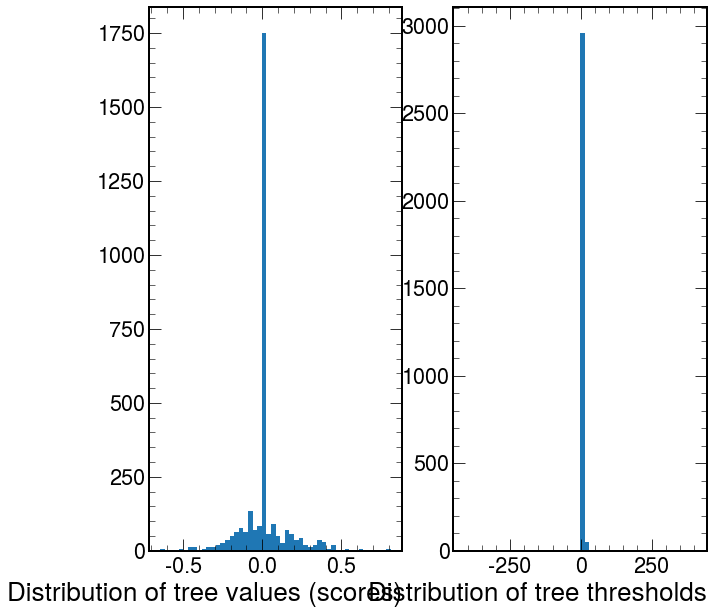

In [19]:
IDmodel_cnf.profile()

In [ ]:
# Synthesize the model
IDmodel_cnf.build(csim=True)

# Calibration model then

In [20]:
CALcfg = conifer.backends.vhdl.auto_config()
CALcfg['OutputDir'] = calibdir+'/BDTmodel_VHDL'
CALcfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'
CALcfg['Precision'] = 'ap_fixed<18,6,AP_RND_CONV,AP_SAT>'

for key in CALcfg:
    print(key, ':', CALcfg[key])

ProjectName : my-prj
OutputDir : /data_CMS/cms/motta/Phase2L1T/2022_10_04_v12/TauBDTCalibratorTraining_lTauPtCut18_lEtacut1.5/BDTmodel_VHDL
Precision : ap_fixed<18,6,AP_RND_CONV,AP_SAT>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 5


In [22]:
# Create and compile the model
CALmodel_cnf = conifer.model(CALmodel, conifer.converters.xgboost, conifer.backends.vhdl, CALcfg)
CALmodel_cnf.compile()

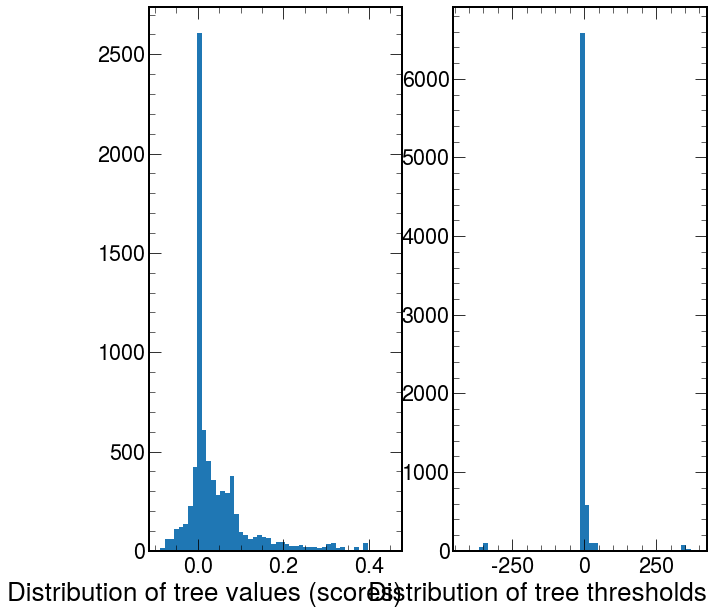

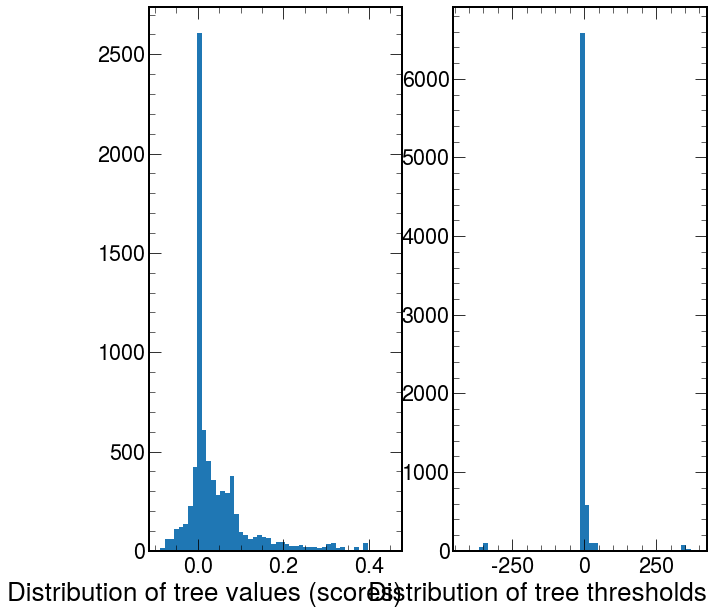

In [23]:
CALmodel_cnf.profile()

In [ ]:
# Synthesize the model
CALmodel_cnf.build(csim=True)

# HLS and XGB comparison

In [43]:
# Run HLS C Simulation and get the output
# xgboost 'predict' returns a probability like sklearn 'predict_proba'
# so we need to compute the probability from the decision_function returned
# by the HLS C Simulation
ID_y_hls = expit(IDmodel_cnf.decision_function(Xident_reduced[IDfeats].values))
auc_hls = metrics.roc_auc_score(Xident_reduced['targetId'],ID_y_hls)
fpr_hls, tpr_hls, threshold_hls = metrics.roc_curve(Xident_reduced['targetId'],ID_y_hls)

In [44]:
ID_y_xgb = IDmodel.predict(xgb.DMatrix(data=Xident_reduced[featuresN]))
auc_xgb = metrics.roc_auc_score(Xident_reduced['targetId'],ID_y_xgb)
fpr_xgb, tpr_xgb, threshold_xgb = metrics.roc_curve(Xident_reduced['targetId'],ID_y_xgb)

In [49]:
# Run HLS C Simulation and get the output
# xgboost 'predict' returns a probability like sklearn 'predict_proba'
# so we need to compute the probability from the decision_function returned
# by the HLS C Simulation
CAL_y_test_hls = (CALmodel_cnf.decision_function(Xcalib_reduced[CALfeats].values))
CAL_y_xgb = CALmodel.predict(xgb.DMatrix(data=Xcalib_reduced[featuresN]))

Test XGB AUROC : 0.9642921183634291
Test HLS AUROC : 0.9093735104240805


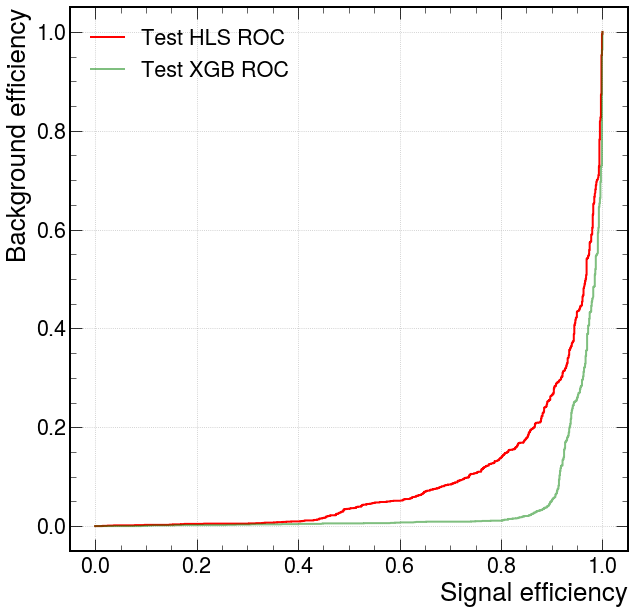

In [45]:
print('Test XGB AUROC :', auc_xgb)
print('Test HLS AUROC :', auc_hls)

plt.figure(figsize=(10,10))
plt.plot(tpr_hls,fpr_hls,label='Test HLS ROC', color='red',lw=2)
plt.plot(tpr_xgb,fpr_xgb,label='Test XGB ROC', color='green',lw=2, alpha=0.5)
plt.grid(linestyle=':')
plt.legend(loc = 'upper left')
#plt.xlim(0.85,1.001)
#plt.yscale('log')
#plt.ylim(0.001,1)
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.show()
plt.close()

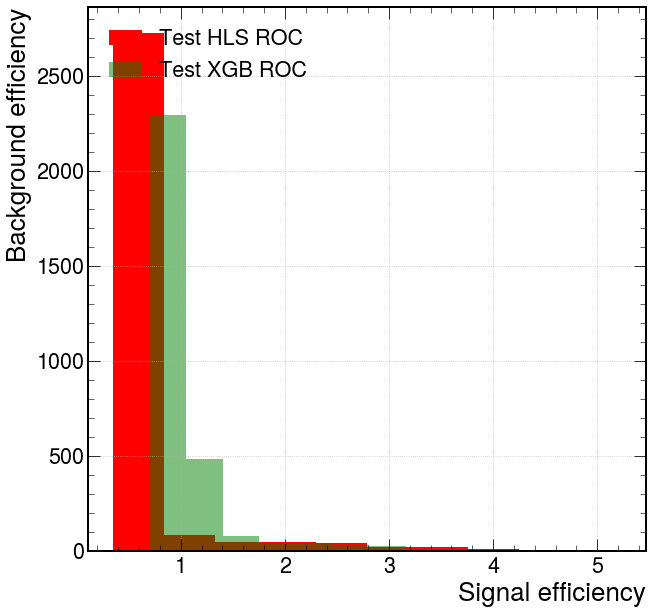

In [50]:
plt.figure(figsize=(10,10))
plt.hist(CAL_y_test_hls,label='Test HLS ROC', color='red',lw=2, histtype='step')
plt.hist(CAL_y_xgb,label='Test XGB ROC', color='green',lw=2, histtype='step')
plt.grid(linestyle=':')
plt.legend(loc = 'upper right')
#plt.xlim(0.85,1.001)
plt.yscale('log')
#plt.ylim(0.001,1)
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.show()
plt.close()